### Imports

In [5]:
import matplotlib.pyplot as plt
import pandas as pd
from tqdm import tqdm
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset, Subset
from torchvision.io import read_image
from torch.optim import Adam
import torchvision.transforms as transforms

from collections import OrderedDict
import os
import json

### Hyperparameters  
* $x$ is a observed variable in dataset $X=\{x^{(i)}\}^N_{i=1}$ consisting of $N$ i.i.d. samples, $x\in\mathbb{R^{\text{x\_dim}}}$  
* $z$ is a latent variable, $z\in\mathbb{R^{\text{z\_dim}}}$ such that $z{\sim}q_{\phi}(z|x)$

In [2]:
annotations_file_train = "./data/train/labels.csv"
img_dir_train = "./data/train/images/"
annotations_file_test = "./data/test/labels.csv"
img_dir_test = "./data/test/images/"

device = "cuda" if torch.cuda.is_available() else "cpu"
workers = 1
learning_rate = 1E-4
batch_size = 50
epochs = 30
# x_dim = 784 is defined by dataset
z_dim = 64
hidden_dim = 256

vae_state_dict = "./runs/9734404/vae-state-dict.pt"

### Class definitions

In [45]:
class MNISTDataset(Dataset):
    def __init__(self, annotations_file, img_dir, transform=None, target_transform=None):
        self.img_labels = pd.read_csv(annotations_file) 
        self.img_dir = img_dir
        self.transform = transform
        self.target_transform = target_transform

    def __len__(self):
        return len(self.img_labels)
    
    def __getitem__(self, idx):
        img_path = os.path.join(self.img_dir, self.img_labels.iloc[idx, 0])
        image = torch.flatten(read_image(img_path)).float() / 255.0
        label = self.img_labels.iloc[idx, 1]
        if self.transform:
            image = self.transform(image)
        if self.target_transform:
            label = self.target_transform(label)
        return image, label
    
class Encoder(nn.Module):
    def __init__(self, x_dim, hidden_dim, z_dim):
        super(Encoder, self).__init__()
        self.linear1 = nn.Linear(x_dim, hidden_dim)
        self.mu = nn.Linear(hidden_dim, z_dim)
        self.log_sigma = nn.Linear(hidden_dim, z_dim)
        self.leaky_relu = nn.LeakyReLU()

    def forward(self, x):
        h = self.leaky_relu(self.linear1(x))
        mean = self.mu(h)
        log_var = self.log_sigma(h)
        return mean, log_var
    
class Decoder(nn.Module):
    def __init__(self, z_dim, hidden_dim, x_dim):
        super(Decoder, self).__init__()
        self.linear1 = nn.Linear(z_dim, hidden_dim)
        self.output = nn.Linear(hidden_dim, x_dim)
        self.leaky_relu = nn.LeakyReLU()

    def forward(self, z):
        h = self.leaky_relu(self.linear1(z))
        x_hat = torch.sigmoid(self.output(h))
        return x_hat
    
class VAE(nn.Module):
    def __init__(self, encoder, decoder):
        super(VAE, self).__init__()
        self.encoder = encoder
        self.decoder = decoder

    def reparameterise(self, mean, var):
        epsilon = torch.randn_like(var)
        z = mean + var * epsilon
        return z
    
    def forward(self, x):
        mean, log_var = self.encoder(x)
        z = self.reparameterise(mean, torch.exp(0.5 * log_var))
        x_hat = self.decoder(z)
        return x_hat, mean, log_var
    
def loss_function(x, x_hat, mean, log_var):
    reconstruction_error = nn.functional.binary_cross_entropy(x_hat, x, reduction="sum")
    kl_divergence = -0.5 * torch.sum(1 + log_var - mean.pow(2) - log_var.exp())
    return kl_divergence + reconstruction_error

### Training

In [14]:
dataset_train = MNISTDataset(annotations_file_train, img_dir_train)
loader_train = DataLoader(Subset(dataset_train, range(10)), batch_size=batch_size, shuffle=True, num_workers=workers)

x_dim = len(dataset_train[0][0])
encoder = Encoder(x_dim, hidden_dim, z_dim)
decoder = Decoder(z_dim, hidden_dim, x_dim)
vae = VAE(encoder, decoder)
vae.to(device)
optimiser = Adam(vae.parameters(), lr=learning_rate)

In [15]:
print("Training VAE...")
vae.train()
i = 1
curr_loss = None
for epoch in range(epochs):
    total_loss = 0
    print(f"Epoch {i}:")
    for batch in tqdm(loader_train):
        optimiser.zero_grad()
        x = batch[0]
        x.to(device)
        x_hat, mean, log_var = vae(x)
        loss = loss_function(x, x_hat, mean, log_var)
        total_loss += loss.item()
        loss.backward()
        optimiser.step()
    print(f"Epoch {i} complete.\tAverage loss: {total_loss / batch_size}")
    i += 1
    curr_loss = total_loss
print("Traning complete.")

Training VAE...
Epoch 1:


100%|██████████| 1/1 [00:00<00:00,  4.16it/s]


Epoch 1 complete.	Average loss: 109.72337890625
Epoch 2:


100%|██████████| 1/1 [00:00<00:00,  2.97it/s]


Epoch 2 complete.	Average loss: 109.301396484375
Epoch 3:


100%|██████████| 1/1 [00:00<00:00,  4.01it/s]


Epoch 3 complete.	Average loss: 109.03318359375
Epoch 4:


100%|██████████| 1/1 [00:00<00:00,  5.15it/s]


Epoch 4 complete.	Average loss: 108.70408203125
Epoch 5:


100%|██████████| 1/1 [00:00<00:00,  4.72it/s]


Epoch 5 complete.	Average loss: 108.27322265625
Epoch 6:


100%|██████████| 1/1 [00:00<00:00,  5.77it/s]


Epoch 6 complete.	Average loss: 107.952275390625
Epoch 7:


100%|██████████| 1/1 [00:00<00:00,  5.63it/s]


Epoch 7 complete.	Average loss: 107.443984375
Epoch 8:


100%|██████████| 1/1 [00:00<00:00,  6.05it/s]


Epoch 8 complete.	Average loss: 107.492666015625
Epoch 9:


100%|██████████| 1/1 [00:00<00:00,  4.84it/s]


Epoch 9 complete.	Average loss: 106.846904296875
Epoch 10:


100%|██████████| 1/1 [00:00<00:00,  5.54it/s]


Epoch 10 complete.	Average loss: 106.821162109375
Epoch 11:


100%|██████████| 1/1 [00:00<00:00,  4.35it/s]


Epoch 11 complete.	Average loss: 106.2800390625
Epoch 12:


100%|██████████| 1/1 [00:00<00:00,  4.80it/s]


Epoch 12 complete.	Average loss: 105.751435546875
Epoch 13:


100%|██████████| 1/1 [00:00<00:00,  5.19it/s]


Epoch 13 complete.	Average loss: 105.549365234375
Epoch 14:


100%|██████████| 1/1 [00:00<00:00,  3.75it/s]


Epoch 14 complete.	Average loss: 105.299716796875
Epoch 15:


100%|██████████| 1/1 [00:00<00:00,  5.52it/s]


Epoch 15 complete.	Average loss: 105.08146484375
Epoch 16:


100%|██████████| 1/1 [00:00<00:00,  4.11it/s]


Epoch 16 complete.	Average loss: 104.6973828125
Epoch 17:


100%|██████████| 1/1 [00:00<00:00,  5.21it/s]


Epoch 17 complete.	Average loss: 104.2399609375
Epoch 18:


100%|██████████| 1/1 [00:00<00:00,  4.24it/s]


Epoch 18 complete.	Average loss: 103.493056640625
Epoch 19:


100%|██████████| 1/1 [00:00<00:00,  4.76it/s]


Epoch 19 complete.	Average loss: 103.244736328125
Epoch 20:


100%|██████████| 1/1 [00:00<00:00,  5.52it/s]


Epoch 20 complete.	Average loss: 103.387490234375
Epoch 21:


100%|██████████| 1/1 [00:00<00:00,  4.66it/s]


Epoch 21 complete.	Average loss: 103.2290625
Epoch 22:


100%|██████████| 1/1 [00:00<00:00,  5.64it/s]


Epoch 22 complete.	Average loss: 102.367451171875
Epoch 23:


100%|██████████| 1/1 [00:00<00:00,  4.89it/s]


Epoch 23 complete.	Average loss: 102.129453125
Epoch 24:


100%|██████████| 1/1 [00:00<00:00,  2.04it/s]


Epoch 24 complete.	Average loss: 101.92791015625
Epoch 25:


100%|██████████| 1/1 [00:00<00:00,  2.66it/s]


Epoch 25 complete.	Average loss: 101.7356640625
Epoch 26:


100%|██████████| 1/1 [00:00<00:00,  3.70it/s]


Epoch 26 complete.	Average loss: 101.4321875
Epoch 27:


100%|██████████| 1/1 [00:00<00:00,  5.16it/s]


Epoch 27 complete.	Average loss: 100.22669921875
Epoch 28:


100%|██████████| 1/1 [00:00<00:00,  5.16it/s]


Epoch 28 complete.	Average loss: 100.984365234375
Epoch 29:


100%|██████████| 1/1 [00:00<00:00,  4.01it/s]


Epoch 29 complete.	Average loss: 100.16048828125
Epoch 30:


100%|██████████| 1/1 [00:00<00:00,  5.02it/s]

Epoch 30 complete.	Average loss: 99.98029296875
Traning complete.


In [16]:
hyperparameters = OrderedDict([
    ("annotations_file_train", annotations_file_train),
    ("img_dir_train", img_dir_train),
    ("annotations_file_test", annotations_file_test),
    ("img_dir_test", img_dir_test),
    ("device", device),
    ("workers", workers),
    ("learning_rate", learning_rate),
    ("batch_size", batch_size),
    ("epochs", epochs),
    ("z_dim", z_dim),
    ("hidden_dim", hidden_dim)
])
log = {
    "hyperparameters": hyperparameters,
    "loss": curr_loss
}
torch.save(vae.state_dict(), "vae-state-dict.pt")
torch.save(optimiser.state_dict(), "optimiser-state-dict.pt")
with open("log.json", 'w') as fp:
    json.dump(log, fp)

### Evaluation

In [64]:
dataset_test = MNISTDataset(annotations_file_test, img_dir_test)
loader_test = DataLoader(dataset_test, batch_size=batch_size, shuffle=False, num_workers=workers)

x_dim = len(dataset_test[0][0])

encoder = Encoder(x_dim, hidden_dim, z_dim)
decoder = Decoder(z_dim, hidden_dim, x_dim)
vae = VAE(encoder, decoder)
vae.load_state_dict(torch.load(vae_state_dict, weights_only=True, map_location=torch.device(device)))
vae.to(device)
vae.eval()

def plot_x(x):
    with torch.no_grad():
        x_hat , _, _ = vae(x)
        x_img = x.view(28, 28).numpy()
        x_hat_img = x_hat.view(28, 28).numpy()
        fig, ax = plt.subplots(1, 2)
        ax[0].imshow(x_img)
        ax[1].imshow(x_hat_img)
        plt.show()

/home/ccheemeng/miniconda3/envs/hpc-mnist-vae/lib/python3.8/site-packages/torch/_utils.py:776: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  return self.fget.__get__(instance, owner)()


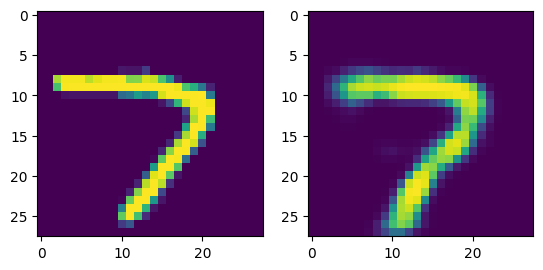

In [71]:
plot_x(dataset_test[69][0])